In [1]:
from PIL import Image
import numpy as np
import cv2

import tensorflow as tf
import tensorflow_hub as hub

import torchvision
import torch
from torch import nn

### This notebook loads a previously trained model and generates x-ray images with it

## Model copied from X-Ray GAN notebook

In [2]:
# All networks should inherit `nn.Module`
class Generator(nn.Module):
    """
    Takes a 100 element input vector and transforms
    it into an image with dimensions 64x64
    
    input is bacth_size x n_ch x width x height.
    In this case, (batch_size, 100, 1, 1)
    """
    
    # Note on convolutional transpose operations:
    # Input: (batch, chs_in, h_in, w_in)
    # Output: (batch, chs_out, h_out, w_out)
    # h_out = (h_in-1) * stride - 2 * padding + kernel
    
    # Anything with optimizable parameters needs to be
    # setup within the init method
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100, 
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            
            # Output Layer
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    # All modules must override `forward`
    def forward(self, x):
        x = self.main(x)
        return x

In [6]:
# Utility methods for displaying data during training
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.figure(figsize = (10,10))
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

## Create a Generator and load the trained model

In [7]:
# Unwrap model after using data parallelization
from collections import OrderedDict
new_trained_gen = OrderedDict()

old_trained_gen = torch.load('/home/seif.younis/Deep Learning and Medical Imaging/examples/Toy GAN/trained models/trained_generator')

for k, v in old_trained_gen.items():
    name = k[7:] # remove `module.`
    new_trained_gen[name] = v

In [8]:
G = Generator()
G.load_state_dict(new_trained_gen)

<All keys matched successfully>

## Generate new images from noise

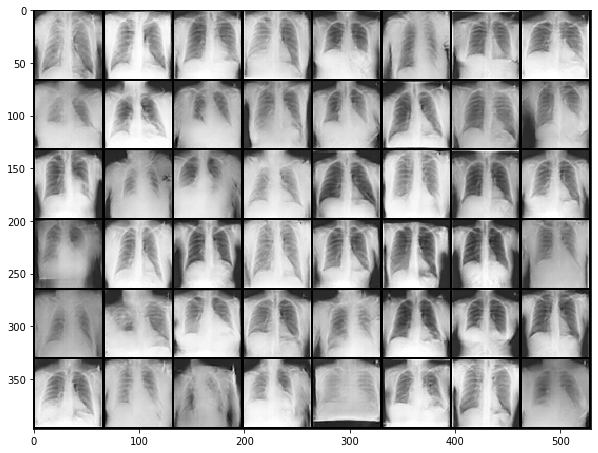

In [9]:
# Noise to generate images from.
# It should be a batch of vectors with 1000 channels.
noise = torch.randn(48, 100, 1, 1)

# Feed noise into the generator to create new images
images = G(noise).detach()

# Preview the imagesz
show_images(images)

Now we're going to use ESRGAN to enhance the resolution of these images

In [13]:
ESRGAN = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(ESRGAN)

In [11]:
def preprocess_image(hr_image):
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    
    return tf.expand_dims(hr_image, 0)

def plot_image(image, title=""):
    """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
    """
    image = np.asarray(image)
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    # plt.subplot(2, 1, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)

def plot_all_images(images):
    plt.figure(figsize=(15, 12))
        
    for n, image in enumerate(images):
        image = np.asarray(image)
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
        
        ax = plt.subplot(6, 8, n + 1)
        ax.imshow(image)
        ax.axis("off")

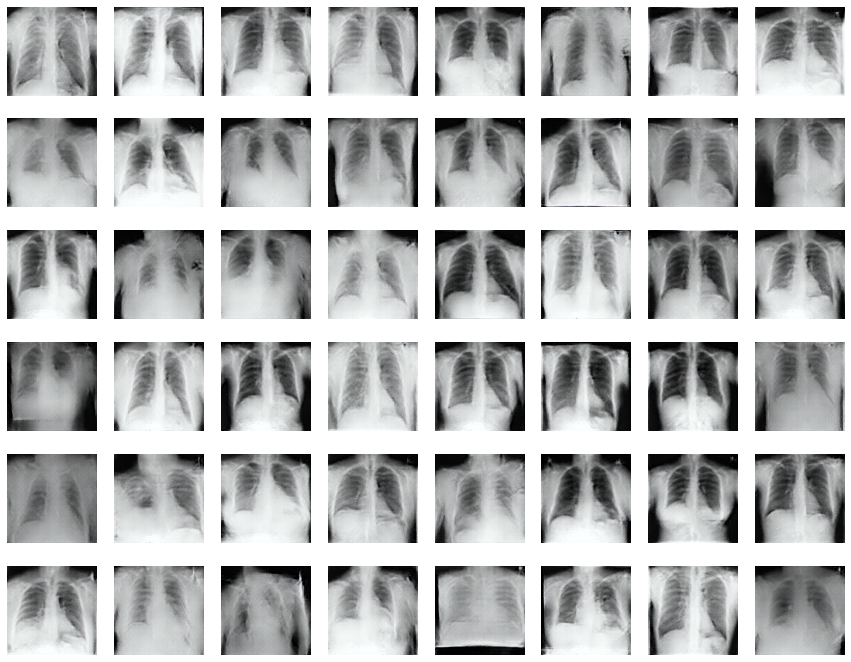

In [14]:
fakes = []
for image in images:
    image = image.numpy() * 255
    image = np.transpose(image, (1, 2, 0))
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    image = preprocess_image(image)
    
    fake_image = model(image)
    fake_image = tf.squeeze(fake_image).numpy()
    fakes.append(fake_image)

plot_all_images(fakes)
# show_images(fakes)